# Problema: ¿Dónde está todo el mundo?


## Background: La Paradoja de Fermi

En 1950, mientras trabajaba en el Proyecto Manhattan, Enrico Fermi formuló la siguiente pregunta: Con la cantidad de estrellas que hay en la Vía Láctea, muchas de las cuales sin duda albergando planetas a su alrededor, seguro que hay una proporción significativa de los mismos con condiciones similares a las de la Tierra. De estos, habrá una proporción que, además, albergarán vida inteligente. Si es así, ¿cómo es que no hemos contactado con nadie? Este adagio es conocido como la Paradoja de Fermi y se considera una paradoja porque la observación empírica (cero extraterretres) contradice la intuición de que, a juzagar por los datos, la Vía Láctea debería rebosar de vida y, en particular, la Especie Humana debería encontrarse en medio de un enjambre de civilizaciones que van de aquí para allá.

Se han propuesto diversas soluciones a la paradoja, desde la más conservadora de que, simplemente, nuestro juicio de los datos es incorrecto hasta las más extravagantes, que sugieren que hay muchas formas de vida pero que la gran mayoría no son computables por nuestros sentidos; pasando por algunas algo ominosas, como que toda civilización debe superar, llegado cierto punto, una suerte de filtro cósmico que suele dar como resultado la extinción en la mayoría de los casos.

En esta actividad vamos a hacer uso de algunos datos para dar una posible respuesta a la Paradoja de Fermi.

# Limpiar y entender el dataset planetas.csv

In [3]:
from google.colab import files
uploaded = files.upload()

Saving planets.csv to planets.csv


In [346]:
import io
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

path = io.BytesIO(uploaded['planets.csv'])
raw_df = pd.read_csv(path, index_col='rowid', skiprows=15)
print(raw_df.shape)
raw_df.info()

(3564, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3564 entries, 1 to 3564
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pl_orbper    3482 non-null   float64
 1   pl_orbsmax   2068 non-null   float64
 2   pl_orbeccen  1133 non-null   float64
 3   pl_orbincl   609 non-null    float64
 4   pl_bmassj    1327 non-null   float64
 5   pl_radj      2805 non-null   float64
 6   pl_dens      460 non-null    float64
 7   st_dist      2418 non-null   float64
 8   st_teff      3375 non-null   float64
 9   st_mass      3249 non-null   float64
 10  st_rad       3184 non-null   float64
dtypes: float64(11)
memory usage: 334.1 KB


**Observaciones**

*   El dataset contiene 11 columnas y 3564 registros. 
*   Para el análisis que vamos a realizar vamos a utilizar 5 columnas relevantes, las cuales son:
  - Periodo orbital (días) =  pl_orbper: Orbital Period [days]
  - Masa (masas de Júpiter) = pl_bmassj: Planet Mass or M*sin(i)[Jupiter mass]
  - Radio (radios de Júpiter) = pl_radj: Planet Radius [Jupiter radii]
  - Temperatura estelar efectiva (grados Kelvin) = st_teff: Effective Temperature [K]
  - Distancia (pársecs) =  st_dist

*   Podemos observar que todas las columnas son numéricas y no hay valores nulos. 
*   El número de registros para cada columna son diferentes.

In [347]:
# Crear un nuevo dataframe con las columnas relevantes que vamos a utilizar. 
planets_df = raw_df[[
    'pl_orbper', 'pl_bmassj', 'pl_radj', 'st_teff', 'st_dist'
]]

# Renombrar las columnas con un nombre más ilustrativo. 
planets_df = planets_df.rename(
    columns={
        'pl_orbper': 'Orbital_Period_d',
        'pl_bmassj': 'Mass_J',
        'pl_radj': 'Radius_J',
        'st_teff': 'Temp_K',
        'st_dist': 'Distance_pc'
    })

# Verificar que no existan valores duplicados en las columnas. 
print(planets_df[planets_df.duplicated(keep=False)])

# Eliminar dos filas que tienen NaN values en todas las columnas 
print(f'Tamaño del set antes de eliminar las filas con NaN: {planets_df.shape}')
planets_df.dropna(axis = 0, how = 'all', inplace = True)
print(f'Tamaño del set después de eliminar las filas con NaN: {planets_df.shape}')

       Orbital_Period_d  Mass_J  Radius_J  Temp_K  Distance_pc
rowid                                                         
3257                NaN     NaN       NaN     NaN          NaN
3258                NaN     NaN       NaN     NaN          NaN
Tamaño del set antes de eliminar las filas con NaN: (3564, 5)
Tamaño del set después de eliminar las filas con NaN: (3562, 5)


In [348]:
planets_df.describe()

,Orbital_Period_d,Mass_J,Radius_J,Temp_K,Distance_pc
count,3.482000e+03,1327.000000,2805.000000,3375.000000,2418.000000
mean,2.549070e+03,2.572577,0.359421,5519.407852,632.868730
std,1.241042e+05,4.231024,0.411342,1741.719988,840.702593
min,9.070629e-02,0.000060,0.029000,575.000000,1.290000
25%,4.645043e+00,0.193500,0.138000,5079.000000,95.157500
50%,1.255604e+01,0.960000,0.205000,5616.000000,494.500000
75%,4.514708e+01,2.640000,0.304000,5935.500000,880.000000
max,7.300000e+06,30.000000,6.900000,57000.000000,8500.000000


# **Observaciones Estadística Descriptiva**


*   La columna **Orbital_Period_d** tiene un valor max de 7.300000e+06 lo cual parece un valor extremo. 
*   La columna **Temp_K** tiene un valor max de 57000. 
*   La distancia media es de 632.87 pc. 

Vamos a verificar los outliers con gráficas tipo "boxplot".

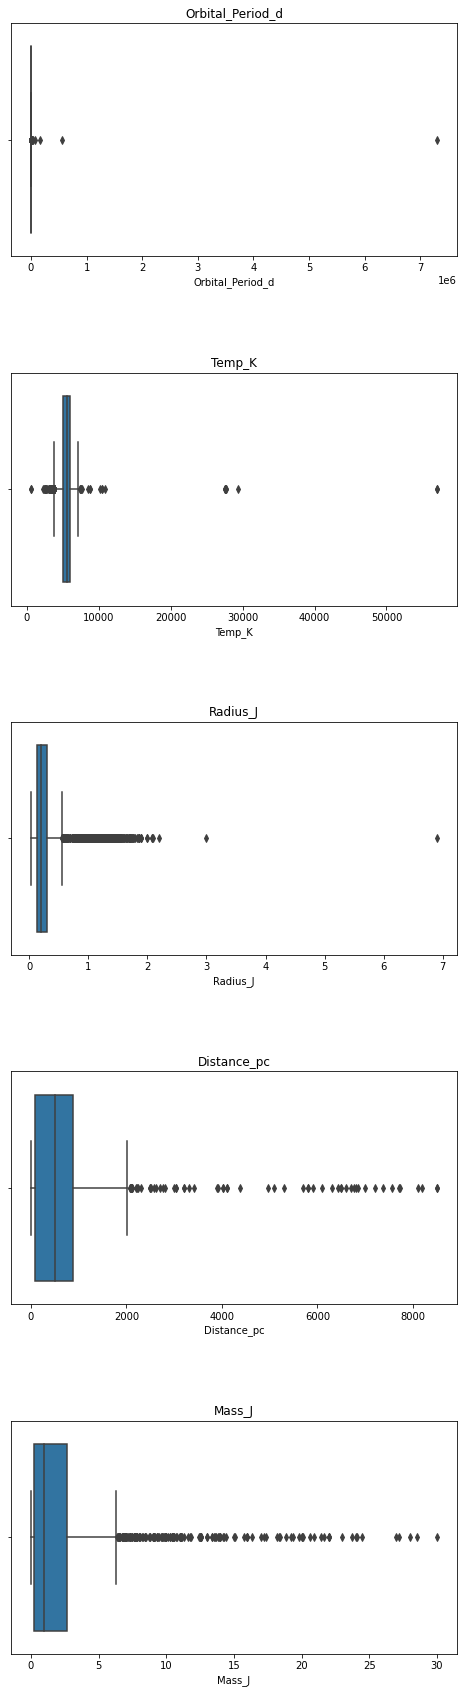

In [288]:
cols_num = ['Orbital_Period_d', 'Temp_K', 'Radius_J','Distance_pc', 'Mass_J' ]

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=planets_df, ax=ax[i])
    ax[i].set_title(col)

In [334]:
print(np.where(planets_df['Orbital_Period_d']>=7300000.0))
print(np.where(planets_df['Temp_K']>=57000))
print(np.where(planets_df['Radius_J']>3))

(array([3330]),)
(array([3286, 3287]),)
(array([250]),)


**Observaciones**

*   Según los boxplots podemos ver que existen outliers, vamos a identificar la cantidad de outliers que tenemos, tener estos outliers no significa que sean datos incorrectos, depende del contexto del problema y al dominio experto del tema se puede decir si se eliminan ó no. 
*   La columna **Orbital_Period** tiene un valor extremo mayor o igual 7300000. 
*   La columna **Temp_K**  tiene dos valores extremos mayores a 57000. 
*   La columna **Radius_J** tiene un valor extremo mayor a 3. 
*   Ya que no tenemos suficiente contexto para afirmar si estos valores realmente corresponden a valores improbables, continuaremos el análisis sin eliminar los outliers. 

## Parte 1: ¿Es la Tierra un planeta común en la Vía Láctea?

Descárgate el fichero planets.csv. En él hallarás datos sobre planetas extrasolares. Establecer una métrica de similitud entre la Tierra y otro planeta es complicado, pero para no forzar demasiado la máquina vamos a trabajar con un modelo muy simplificado. Supondremos que un planeta es homologable a la Tierra si sus valores para los siguientes parámetros no son más de un 10% distintos a los de la Tierra:
1. Periodo orbital (en días)
2. Masa (en masas de Júpiter)
3. Radio (en radios de Júpiter)
4. Temperatura estelar efectiva (en grados Kelvin)

La condición 4 resulta de relevancia evidente para nuestra supervivencia. La 1 puede o no ser relevante, pero cuanto más parecida a la de la Tierra menos probabilidad de fluctuaciones caóticas en el clima. La 3 y la 4 tienen que ver con la gravedad en la superfície del planeta, esta sí, de críticas consecuencias para una vida homologable a la humana.

Los valores de la Tierra son los siguientes:
1. 365.256 días
2. 0.0031453 masas de Júpiter
3. 0.08856 radios de Júpiter
4. 5500 K



A partir del fichero de datos, estima la media y la desviación de estas 4 métricas para todos los planetas de la Via Láctea. Suponiendo que todas ellas siguen una distribución normal con los parámetros obtenidos y que se trata de medidas independientes, calcula la probabilidad de que un planeta de la Vía Láctea escogido al azar sea similar a la Tierra.

In [349]:
# Valores de la Tierra
tolerance = 0.10
earth_orbper_days = 365.256
earth_massj = 0.0031453
earth_radj = 0.08856
earth_temp_k = 5500

# Calcular la media Y la desviación estándar 
empiric_mean = np.mean(
    planets_df.loc[:, ['Orbital_Period_d', 'Mass_J', 'Radius_J', 'Temp_K']],
    axis=0)
empiric_std = np.std(
    planets_df.loc[:, ['Orbital_Period_d', 'Mass_J', 'Radius_J', 'Temp_K']],
    axis=0)

print("La media de las 4 métricas de los planetas de la Via Láctea es: {}".
      format(np.round(empiric_mean, 3)))

print(
    "La desviación estándar de las 4 métricas de los planetas de la Via Láctea es: {}"
    .format(np.round(empiric_std,3)))

# Valores de tolerancia para que un planeta sea considerado similar a la tierra
earth_orbper_max = earth_orbper_days + (earth_orbper_days * tolerance)
earth_orbper_min = earth_orbper_days - (earth_orbper_days * tolerance)

earth_mass_max = earth_massj + (earth_massj * tolerance)
earth_mass_min = earth_massj - (earth_massj * tolerance)

earth_rad_max = earth_radj + (earth_radj * tolerance)
earth_rad_min = earth_radj - (earth_radj * tolerance)

earth_temp_max = earth_temp_k + (earth_temp_k * tolerance)
earth_temp_min = earth_temp_k - (earth_temp_k * tolerance)

cond_mass = ((earth_mass_min <= planets_df['Mass_J']) &
             (planets_df['Mass_J'] <= earth_mass_max))
cond_orb = ((earth_orbper_min <= planets_df['Orbital_Period_d']) &
            (planets_df['Orbital_Period_d'] <= earth_orbper_max))
cond_rad = ((earth_rad_min <= planets_df['Radius_J']) &
            (planets_df['Radius_J'] <= earth_rad_max))
cond_temp = ((earth_temp_min <= planets_df['Temp_K']) &
             (planets_df['Temp_K'] <= earth_temp_max))

La media de las 4 métricas de los planetas de la Via Láctea es: Orbital_Period_d    2549.070
Mass_J                 2.573
Radius_J               0.359
Temp_K              5519.408
dtype: float64
La desviación estándar de las 4 métricas de los planetas de la Via Láctea es: Orbital_Period_d    124086.378
Mass_J                   4.229
Radius_J                 0.411
Temp_K                1741.462
dtype: float64


In [350]:
p_orbper = norm.cdf(x=earth_orbper_max,
                    loc=empiric_mean["Orbital_Period_d"],
                    scale=empiric_std["Orbital_Period_d"]) - norm.cdf(
                        x=earth_orbper_min,
                        loc=empiric_mean["Orbital_Period_d"],
                        scale=empiric_std["Orbital_Period_d"])

p_orbper

0.00023482592942880576

In [351]:
p_mass = norm.cdf(
    x=earth_mass_max, loc=empiric_mean["Mass_J"],
    scale=empiric_std["Mass_J"]) - norm.cdf(x=earth_mass_min,
                                            loc=empiric_mean["Mass_J"],
                                            scale=empiric_std["Mass_J"])

p_mass

4.9337538981175655e-05

In [352]:
p_temp = norm.cdf(
    x=earth_temp_max, loc=empiric_mean["Temp_K"],
    scale=empiric_std["Temp_K"]) - norm.cdf(x=earth_temp_min,
                                            loc=empiric_mean["Temp_K"],
                                            scale=empiric_std["Temp_K"])

p_temp

0.24785098490604696

In [353]:
p_rad = norm.cdf(x=earth_rad_max,
                 loc=empiric_mean["Radius_J"],
                 scale=empiric_std["Radius_J"]) - norm.cdf(
                     x=earth_rad_min,
                     loc=empiric_mean["Radius_J"],
                     scale=empiric_std["Radius_J"])

p_rad

0.013830717167380768

In [354]:
prob_sim_earth = p_orbper * p_mass * p_rad * p_temp
print(
    "Probabilidad de que un planeta de la via láctea sea similar a la tierra es: {0}"
    .format(prob_sim_earth))

Probabilidad de que un planeta de la via láctea sea similar a la tierra es: 3.971539458550295e-11


## Parte 2: La Tierra, ¿dónde queda?

Usa métodos de estimación para dilucidar, con una confianza del 99%, cuál es la distancia media entre la Tierra y un planeta cualquiera de la Vía Láctea. ¿Es la Tierra un lugar remoto de la galaxia?

In [355]:
# Calcular la distancia media entre la Tierra y un planeta cualquiera
empiric_mean_distance = np.mean(planets_df.Distance_pc)
empiric_std_distance = np.std(planets_df.Distance_pc)
dist_media = 0
alpha = 0.01
z = norm.ppf(1. - alpha / 2.)
correction = z * empiric_std_distance / np.sqrt(len(planets_df))
IC_dist_earth = [
    empiric_mean_distance - correction, empiric_mean_distance + correction
]

print(f"IC para la Distancia media: {IC_dist_earth}", flush=True)

dist_media = planets_df[
    (planets_df.Distance_pc <= (empiric_mean_distance + correction))
    & (planets_df.Distance_pc >=
       (empiric_mean_distance - correction))].Distance_pc.mean()
print(
    f"La distancia media entre la Tierra y un planeta cualquiera de la Vía Láctea es: {dist_media} pc"
)

IC para la Distancia media: [596.5924553260612, 669.1450053852706]
La distancia media entre la Tierra y un planeta cualquiera de la Vía Láctea es: 633.4994696969696 pc


## Parte 3: Pues eso, que dónde está todo el mundo.

Aquí la distancia se da en pársecs, que equivalen a 3.1 años luz. Un año luz es la distancia cubierta por un fotón durante un año viajando por el vacío. En km equivale a un número absurdamente grande en términos humanamente cotidianos. Las leyes de la física impiden moverse a velocidades cercanas a la luz sin sufrir efectos extravagantes y desgradables, así que vamos a suponer que, en el mejor de los casos, una especie lo suficientemente avanzada puede viajar al 20% de la velocidad de la luz. Vamos a suponer también que el Universo tiene una topología lo bastante regular como para que no se puedan hacer trampas como atravesar agujeros de gusano, teletransportarse u obrar cualquier otro tipo de magia.

a) Suponiendo que el Homo Sapiens tiene una antigüedad de 200.000 años, estima el tiempo medio que tardaremos en contactar con una especie extraterrestre que emprendiera su viaje hacia la Tierra justo cuando nosotros comenzamos a pulular por el planeta.

b) Suponiendo, además, que dicha especie no tiene modo de saber a priori si un planeta albergará anfitriones y, por lo tanto, escoge uno al azar de entre los que tienen potencial, recalcula tu estimación sobre tiempo que tardaremos en recibir a alguien por casa.

c) Reflexiona sobre los resultados y razona hasta qué punto nos encontramos ante una paradoja. ¿Respaldan los datos la idea de que deberíamos haber contactado con otras civilizaciones extraterrestres?


In [356]:
# Parte a. Tiempo medio que tardaremos en contactar con una especie extraterrestre
homo_sapiens_y = 200000

# ly/pc
one_parsec = 3.1

#lightspeed pc/y. Especie puede viajar al 20% de la velocidad de la luz
light_speed_in_pc_per_year = 0.307
const_galaxy_speed = light_speed_in_pc_per_year * 0.20

#To calculate the time we can use the formula t=d/v. dist(pc)/(pc/y)
mean_time = dist_media / const_galaxy_speed

print(
    f"El tiempo promedio para recorrer la distancia media de la tierra es: {np.round(mean_time, 3)} años"
)

El tiempo promedio para recorrer la distancia media de la tierra es: 10317.581 años


In [357]:
# Parte b

#Get the distance using the IC de la distancia y la probabilidad de que un planeta sea similar a la tierra.
distance_azar_sim_earth = np.array(IC_dist_earth) / (0.2 /
                                                    3.1) / prob_sim_earth

#Calculate the time 
mean_time = np.divide(distance_azar_sim_earth, const_galaxy_speed)

print(
    f"El tiempo para recorrer la distancia media de un planeta similar a la tierra escogido al azar es: {mean_time} años"
)

El tiempo para recorrer la distancia media de un planeta similar a la tierra escogido al azar es: [3.79212114e+15 4.25328697e+15] años


### Conclusión a la pregunta ¿dónde están todos? 

De acuerdo con los datos que analizamos, podemos concluir lo siguiente: 

**1.** Consideramos cuatro métricas para poder establecer si un planeta es similar a la tierra.  Las 4 métricas son: 

|    **Metric**    | **Values** |
|:---------------- |-----------:|
| Orbital_Period_d |    365.256 |
| Mass_J           |  0.0031453 |
| Radius_J        |    0.08856 |
| Temp_K           |       5500 |

La probabilidad de encontrar un planeta similar a la tierra, es decir que cumpla las 4 métricas que permiten que exista la vida en la tierra como la conocemos, es de 3.97e-11. Es una probabilidad muy baja por lo tanto podriamos concluir que para el set de datos analizados no existe un planeta que sea similar a la tierra. 

**2.** La distancia media entre un planeta cualquiera y la tierra con una confianza del 99% es 633.50 pc.   

**3.** El tiempo promedio para recorrer la distancia media de la tierra es: 10317.581 años

**4.** El tiempo para recorrer la distancia media de un planeta similar a la tierra escogido al azar es: 4.25e+15 años

**5.** A la pregunta **dónde están todos?** Podemos responder basados en los datos lo siguiente: 

  *   Según la probabilidad calculada es muy poco probable que encontremos un planeta similar a las condiciones de la tierra para albergar vida como la conocemos. 
  *   El tiempo promedio para recorrer la distancia media de la tierra es muy grande, por lo cual estamos muy lejos los unos de los otros, lo que nos impide detectar vida fuera de la tierra o simplemente no tenemos la suficiente tecnología para hacerlo. 
  *   Puede que existan otras formas de vida que no podemos detectar con las condiciones que conocemos, la NASA es su programa de investigación para la búsqueda de planetas habitables exoplanets, lanzó en el año 2009 la misión espacial Kepler, el cual es un telescopio espacial con el objetivo de descrubir planetas similares a las condiciones de la tierra orbitando otras estrellas, hasta la fecha no han logrado descrubir ningún planeta similar. Fuente: [NASA Search for habitable planets](https://www.jpl.nasa.gov/news/in-the-zone-how-scientists-search-for-habitable-planets). 

  *   Investigadores del instituto del futuro de la humanidad de la universidad de Oxford, publicaron en el año 2018 un estudio llamado "Dissolving the Fermi Paradox" y una de las conclusiones fue: "we find a substantial probability that we are alone in our galaxy, and perhaps even in our observable universe (53%–99.6% and 39%–85% respectively). ’Where are they?’ — probably extremely far away, and quite possibly beyond the cosmological horizon and forever unreachable". Fuente: [Dissolving the Fermi Paradox](https://arxiv.org/pdf/1806.02404.pdf)